## Importations

In [1]:
## plots
import matplotlib.pyplot as plt
from matplotlib import rc

import sys
sys.path.append('../')

## ML :
from scripts.machine_learning_utils import *
from scripts.models import *
from scripts.descriptors import *
from scipy.stats import pearsonr

rc('font', family='sans-serif', size = 7)
rc('figure', dpi= 700)
rc(('xtick', 'ytick'), labelsize = 7)
rc('legend', fontsize=6)
rc('lines', linewidth = 1)
rc('axes', linewidth = 0.5, labelsize =8)
rc('legend', handlelength = 2)

Skipped loading some PyTorch models, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'torch'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


## Get data

In [2]:
df_total = pd.read_csv('../tables/data/df_total.csv').set_index('SMILES')

df_OCO = df_total[df_total.group == 'OCO']
df_ONO = df_total[df_total.group == 'ONO']
df_NNN = df_total[df_total.group == 'NNN']
df_triarylboranes = df_total[df_total.group == "triarylboranes"]

## Util functions

In [3]:
def reduce_descr(S, descriptors, names, reduced_features):
    if S == 'ONO':
        X = create_descriptors(df_ONO.index, descriptors, data = data_Q_tot, structure = S)
        df_X = pd.DataFrame(X)
        df_X.columns = names
        df_X_reduced = df_X.loc[:,reduced_features]
        X_reduced = np.array(df_X_reduced)
        Y = df_ONO.FIA
    if S == 'NNN':
        X = create_descriptors(df_NNN.index, descriptors, data = data_Q_tot, structure = S)
        df_X = pd.DataFrame(X)
        df_X.columns = names
        df_X_reduced = df_X.loc[:,reduced_features]
        X_reduced = np.array(df_X_reduced)
        Y = df_NNN.FIA
    if S == 'OCO':
        X = create_descriptors(df_OCO.index, descriptors, data = data_Q_tot, structure = S)
        df_X = pd.DataFrame(X)
        df_X.columns = names
        df_X_reduced = df_X.loc[:,reduced_features]
        X_reduced = np.array(df_X_reduced)
        Y = df_OCO.FIA
    if S == 'triarylboranes':
        X = create_descriptors(df_triarylboranes.index, descriptors, data = data_Q_tot, structure = S)
        df_X = pd.DataFrame(X)
        df_X.columns = names
        df_X_reduced = df_X.loc[:,reduced_features]
        X_reduced = np.array(df_X_reduced)
        Y = df_triarylboranes.FIA 
        
    return(X, X_reduced, Y)

def df(S):
    if S == 'ONO':
        return df_ONO
    if S == 'NNN':
        return df_NNN
    if S == 'OCO':
        return df_OCO
    if S == 'triarylboranes':
        return df_triarylboranes



## Evaluate models without feature selection

In [4]:
structures = ['ONO', 'NNN', 'OCO', 'triarylboranes']

df_results = pd.DataFrame(columns = structures, index=structures)

In [5]:
descriptors = "quantum"
model = 'LR'

for S1 in structures :
    X_S1 = create_descriptors(df(S1).index, descriptors, data = data_Q_tot, structure = S1)
    Y_S1 = df(S1).FIA
    for S2 in structures :
        if S2 == S1 :
            total_Y_S_test, total_Y_S_pred_test, list_MAE_S = K_Fold_model_evaluation(dict_models[model][descriptors],
                                                                                      X_S1,Y_S1,n_fold=10, n_repet=5)
            z = np.polyfit(total_Y_S_test, total_Y_S_pred_test, 1)
            df_results[S1][S2]=f'MAE = {round(np.mean(list_MAE_S),2)} \na = {round(z[0],2)} \nb = {round(z[1],2)}'
        else :
            X_S2 = create_descriptors(df(S2).index, descriptors, data = data_Q_tot, structure = S2)
            Y_S2 = df(S2).FIA
            Y_pred_S2_train_S1, MAE_S1_S2 = train_predict(X_S1, X_S2, Y_S1, Y_S2, dict_models[model][descriptors])
            z = np.polyfit(Y_S2, Y_pred_S2_train_S1, 1)
            df_results[S1][S2]=f'MAE = {round(MAE_S1_S2,2)} \na = {round(z[0],2)} \nb = {round(z[1],2)}'
            
    

In [252]:
df_results.to_excel('../results/extrapolation/extrapolating_results_without_feature_selection_rdkit_ridge.xlsx')

In [8]:
df_results

,ONO,NNN,OCO,triarylboranes
ONO,MAE = 7.01 \na = 0.97 \nb = 12.73,MAE = 4264.8 \na = 1.0 \nb = 4263.0,MAE = 3192.2 \na = 0.61 \nb = 3345.23,MAE = 126.11 \na = 0.74 \nb = 229.75
NNN,MAE = 1827.56 \na = 0.86 \nb = -1782.1,MAE = 10.65 \na = 0.96 \nb = 14.17,MAE = 3990.77 \na = 0.56 \nb = -3851.13,MAE = 141.1 \na = 0.62 \nb = 259.62
OCO,MAE = 1011.46 \na = 1.04 \nb = -1023.49,MAE = 2209.3 \na = 0.97 \nb = 2218.54,MAE = 9.79 \na = 0.89 \nb = 38.28,MAE = 130.58 \na = 0.88 \nb = 172.98
triarylboranes,MAE = 3477.74 \na = 0.68 \nb = -3353.95,MAE = 4909.59 \na = 9.65 \nb = -8256.85,MAE = 9326.69 \na = -0.73 \nb = -8656.08,MAE = 28.62 \na = 0.81 \nb = 73.5


#### ONO > NNN

In [5]:
df_model_NNN = pd.DataFrame(columns = dict_models.keys())

In [9]:
S1='ONO'
S2 = 'NNN'
descriptors = "rdkit"

X_S1 = create_descriptors(df(S1).index, descriptors, data = data_Q_tot, structure = S1)
X_S2 = create_descriptors(df(S2).index, descriptors, data = data_Q_tot, structure = S2)
Y_S1 = df(S1).FIA
Y_S2 = df(S2).FIA

In [30]:
for model in df_model_NNN.columns :
    Y_pred_S2_train_S1, MAE_S1_S2 = train_predict(X_S1, X_S2, Y_S1, Y_S2, dict_models[model][descriptors])
    z = np.polyfit(Y_S2, Y_pred_S2_train_S1, 1)
    df_model_NNN.at["performance",model]=f'MAE = {round(MAE_S1_S2,1)} \na = {round(z[0],2)} \nb = {round(z[1],1)}'

In [33]:
df_model_NNN

,Linear,Ridge,Bayes. Ridge,Lasso,SVR,Tree,RF,GB,GPR,KNN,MLP
performance,MAE = 54.1 \na = 0.89 \nb = -18.8,MAE = 187.8 \na = 0.88 \nb = 226.6,MAE = 227.3 \na = 0.88 \nb = 266.5,MAE = 163.6 \na = 0.88 \nb = 200.9,MAE = 86.5 \na = 0.86 \nb = 130.1,MAE = 76.3 \na = 0.81 \nb = 135.1,MAE = 71.2 \na = 0.84 \nb = 121.5,MAE = 61.9 \na = 0.76 \nb = 137.3,MAE = 86.4 \na = 0.0 \nb = 396.7,MAE = 60.2 \na = 0.45 \nb = 231.3,MAE = 24.1 \na = 0.89 \nb = 13.5


In [32]:
df_model_NNN.to_excel('../results/extrapolation/extrapolating_results_without_feature_selection_quantum_ONO-NNN.xlsx')

### Extrapolation training on different structures so that the model can learn the difference

In [ ]:
model = 'LR'
descriptors = 'rdkit'

In [226]:
df_train = df_total[(df_total.group == 'ONO') | (df_total.group=='triarylboranes') ]

In [227]:
df_test = df_NNN

In [228]:
descriptors = 'quantum'

X_train = create_descriptors(df_train.index, descriptors, data= data_Q_tot)
Y_train = df_train.FIA

X_test = create_descriptors(df_test.index, descriptors, data=data_Q_tot)
Y_test = df_test.FIA

In [ ]:
model = 'LR'
Y_pred, MAE = train_predict(X_train, X_test, Y_train, Y_test, dict_models[model][descriptors])

In [230]:
MAE

12.866711882726879

In [28]:
df_training_3_str = pd.DataFrame(columns = ['ONO', 'NNN', 'OCO', 'triarylboranes'])

for structure in df_training_3_str.columns:
    print(structure)
    #S_test = structure
    L = list(df_training_3_str.columns)
    L.remove(structure)
    S_train_1, S_train_2, S_train_3 = L[0], L[1], L[2]
    print("training structure are", S_train_1, S_train_2, S_train_3)
    df_train = df_total[(df_total.group == S_train_1) | (df_total.group == S_train_2) | (df_total.group==S_train_3)]
    df_test = df(structure)
    X_train = create_descriptors(df_train.index, descriptors, data= data_Q_tot)
    Y_train = df_train.FIA

    X_test = create_descriptors(df_test.index, descriptors, data=data_Q_tot)
    Y_test = df_test.FIA
    Y_pred, MAE = train_predict(X_train, X_test, Y_train, Y_test, dict_models[model][descriptors])
    
    z = np.polyfit(Y_test, Y_pred, 1)
    df_training_3_str.at["performance",structure]=f'MAE = {round(MAE,2)} \na = {round(z[0],2)} \nb = {round(z[1],2)}'

ONO
training structure are NNN OCO triarylboranes
NNN
training structure are ONO OCO triarylboranes
OCO
training structure are ONO NNN triarylboranes
triarylboranes
training structure are ONO NNN OCO


In [30]:
df_training_3_str.to_excel('../results/extrapolation/extrapolation_performances_3_structures_training_rdkit.xlsx')

In [29]:
df_training_3_str

,ONO,NNN,OCO,triarylboranes
performance,MAE = 37.7 \na = 0.81 \nb = 37.66,MAE = 56.25 \na = 0.72 \nb = 145.36,MAE = 56.42 \na = 0.98 \nb = 62.64,MAE = 87.41 \na = 1.08 \nb = -93.03


In [247]:
df_training_2_str = pd.DataFrame(columns = ['ONO', 'NNN', 'OCO'])

for structure in df_training_2_str.columns:
    print(structure)
    #S_test = structure
    L = list(df_training_2_str.columns)
    L.remove(structure)
    S_train_1, S_train_2 = L[0], L[1]
    print("training structure are", S_train_1, S_train_2)
    df_train = df_total[(df_total.group == S_train_1) | (df_total.group == S_train_2)]
    df_test = df(structure)
    X_train = create_descriptors(df_train.index, descriptors, data= data_Q_tot)
    Y_train = df_train.FIA

    X_test = create_descriptors(df_test.index, descriptors, data=data_Q_tot)
    Y_test = df_test.FIA
    Y_pred, MAE = train_predict(X_train, X_test, Y_train, Y_test, dict_models[model][descriptors])
    
    z = np.polyfit(Y_test, Y_pred, 1)
    df_training_2_str.at["performance",structure]=f'MAE = {round(MAE,2)} \na = {round(z[0],2)} \nb = {round(z[1],2)}'

ONO
training structure are NNN OCO
NNN
training structure are ONO OCO
OCO
training structure are ONO NNN


In [248]:
df_training_2_str 

,ONO,NNN,OCO
performance,MAE = 42.54 \na = 0.92 \nb = -11.73,MAE = 83.5 \na = 0.9 \nb = -52.42,MAE = 45.28 \na = 0.91 \nb = -13.14


In [249]:
df_training_2_str.to_excel('../results/extrapolation/extrapolation_performances_2_structures_training_not_triarylboranes.xlsx')

### Correlations

Create a table of quantum descriptors (features = columns) for each molecule (row)

In [4]:
descriptors = 'quantum'
names = get_names(descriptors)

In [5]:
X_total = create_descriptors(df_total.index, descriptors, data = data_Q_tot)
df_X_total = pd.DataFrame(X_total)

In [6]:
df_X_total.columns = names

In [7]:
df_X_total['FIA']= list(df_total.FIA)

In [8]:
L=list(df_X_total.corr("spearman")['FIA'].drop('FIA'))
df_correlation = pd.DataFrame()
df_correlation['features']= names
df_correlation['corr with FIA']= [np.round(abs(x),3) for x in L]


In [15]:
df = df_correlation.set_index('features').sort_values('corr with FIA', ascending = False)

In [16]:
df

,corr with FIA
features,
homo_energy,0.749
electronegativity,0.704
lumo_energy,0.628
G_thermal_correction,0.448
zero_point_correction,0.403
G,0.378
H,0.378
E,0.378
E_zpe,0.378


In [40]:
df.to_excel('../results/extrapolation/quantum_features_correlation_with_FIA.xlsx')

### Features that vary a lot between molecular structures

In [11]:
## create descriptors
X_ONO = create_descriptors(df_ONO.index, descriptors, data = data_Q_tot)
X_NNN = create_descriptors(df_NNN.index, descriptors, data = data_Q_tot)
X_OCO = create_descriptors(df_OCO.index, descriptors, data = data_Q_tot)

## convert descriptors to dataframes

df_X_ONO = pd.DataFrame(X_ONO)
df_X_NNN = pd.DataFrame(X_NNN)
df_X_OCO = pd.DataFrame(X_OCO)

df_X_ONO.columns = names
df_X_NNN.columns = names
df_X_OCO.columns = names

In [12]:
df_mean = pd.DataFrame() ## create a table of mean feature value for each structure ONO and NNN
df_mean["NNN"] = list(df_X_NNN.mean())
df_mean["ONO"] = list(df_X_ONO.mean())
df_mean.index = names

In [13]:
## to get the features that vary the most from one structure to another
df_mean['deviation']= np.round(abs((df_mean['NNN']-df_mean['ONO'])/((df_mean['NNN']+df_mean['ONO'])/2)),3)
df_mean = df_mean.dropna()
df_mean_sorted = df_mean.sort_values('deviation', ascending = False)
df_mean_sorted.to_excel('../results/extrapolation/table_SI_quantum_NNN_ONO_mean_features.xlsx')

In [14]:
df_mean_sorted

,NNN,ONO,deviation
X,-0.000138,-0.000823,1.424
lumo_energy,-0.002458,-0.010458,1.239
Z,-0.010290,-0.003291,1.031
NPA_Rydberg,0.016295,0.029452,0.575
ES_root_NPA_Rydberg,0.016745,0.029911,0.564
NMR_anisotropy,16.345397,11.588144,0.341
dipole,4.841390,3.584069,0.298
Y,-0.537898,-0.689481,0.247
ES_root_NPA_charge,1.044553,1.280722,0.203
NPA_charge,1.048219,1.257998,0.182


### Recursive feature selection

In [ ]:
## find the features that deviates the slope and/or that add a bias

descriptors = 'rdkit'
model = dict_models['LR'][descriptors]

X_ONO = create_descriptors(df_ONO.index, descriptors, data = data_Q_tot, structure = 'ONO')
X_NNN = create_descriptors(df_NNN.index, descriptors, data = data_Q_tot, structure = 'NNN')
Y_ONO = df_ONO.FIA
Y_NNN = df_NNN.FIA

names = get_names(descriptors)

df_X_ONO = pd.DataFrame(X_ONO)
df_X_ONO.columns=names
df_X_NNN = pd.DataFrame(X_NNN)
df_X_NNN.columns=names

all_features = names[:]






print('nb of starting features :', len(feature_names))


# on peut raffiner successivement en éliminant les features 
# trouvées au dernier lancement de l'algo

features_to_rm = []

for feature in all_features :
    #print(feature)

    reduced_features = all_features[:]
    reduced_features.remove(feature)
    

    df_X_ONO_reduced = df_X_ONO.loc[:,reduced_features]
    X_ONO_reduced = np.array(df_X_ONO_reduced)

    df_X_NNN_reduced = df_X_NNN.loc[:,reduced_features]
    X_NNN_reduced = np.array(df_X_NNN_reduced)
    
    X_train, X_test, Y_train, Y_test = X_ONO_reduced, X_NNN_reduced, Y_ONO, Y_NNN
    Y_pred_test,  MAE = train_predict(X_train, X_test, Y_train, Y_test, model)
    
    FIA_calc_NNN_train_ONO = Y_test
    FIA_pred_NNN_train_ONO = Y_pred_test
    z = np.polyfit(FIA_calc_NNN_train_ONO, FIA_pred_NNN_train_ONO, 1)
    pente = z[0]
    b = z[1]
    
    #if -100< b < 100 and 0.2 < pente < 2:
    if MAE < 86:
        #print(reduced_features)
        features_to_rm.append(feature)
        
        
        
        FIA_calc_ONO, FIA_pred_ONO, list_MAE_ONO = K_Fold_model_evaluation(model,X_ONO_reduced,Y_ONO,n_fold=10, n_repet=5)
        
        
        FIA_calc_NNN, FIA_pred_NNN, list_MAE_NNN = K_Fold_model_evaluation(model,X_NNN_reduced,Y_NNN,n_fold=10, n_repet=5)

        p = np.poly1d(z)
        
        S1 = 'ONO'
        S2 = 'NNN'
        
        print(feature)
        print(f"MAE {S1} = {round(np.mean(list_MAE_ONO),2)}")
        print(f"MAE {S2} = {round(np.mean(list_MAE_NNN),2)}")
        print(f"MAE {S1}->{S2} = {round(MAE,2)}")
        
        plt.scatter(x=FIA_calc_NNN_train_ONO, y=FIA_pred_NNN_train_ONO,c = 'purple', s = 80, alpha=0.3, label='S2 trained on S1')
        
        plt.plot(FIA_calc_NNN_train_ONO,p(FIA_calc_NNN_train_ONO),"#F8766D", label = f"fit $y=a \cdot x+b$ \na = {round(z[0],2)} \nb = {round(z[1],2)}")
        plt.tight_layout()
        plt.legend()
        plt.show()
        
print(features_to_rm)

nb of starting features : 36
[]


### Test selected features

#### Quantum descriptors

In [4]:
get_names("quantum")

array(['E', 'ES_root_dipole', 'ES_root_electronic_spatial_extent',
       'ES_root_molar_volume', 'E_scf', 'E_thermal_correction', 'E_zpe',
       'G', 'G_thermal_correction', 'H', 'H_thermal_correction', 'charge',
       'converged', 'dipole', 'electronegativity',
       'electronic_spatial_extent', 'hardness', 'homo_energy',
       'lumo_energy', 'molar_mass', 'molar_volume', 'multiplicity',
       'number_of_atoms', 'zero_point_correction', 'APT_charge',
       'ES_root_Mulliken_charge', 'ES_root_NPA_Rydberg',
       'ES_root_NPA_charge', 'ES_root_NPA_core', 'ES_root_NPA_total',
       'ES_root_NPA_valence', 'Mulliken_charge', 'NMR_anisotropy',
       'NMR_shift', 'NPA_Rydberg', 'NPA_charge', 'NPA_core', 'NPA_total',
       'NPA_valence', 'VBur', 'X', 'Y', 'Z'], dtype='<U33')

In [8]:
reduced_features_quantum = ['E', 'ES_root_electronic_spatial_extent',
      'ES_root_molar_volume',
                    'E_scf', 'E_thermal_correction', 'E_zpe',
       'G', 'G_thermal_correction', 'H', 'H_thermal_correction', 
       'electronegativity',
       'electronic_spatial_extent', 'hardness', 'homo_energy',
        'molar_mass', 'molar_volume', 
       'number_of_atoms', 'zero_point_correction', 'APT_charge',
       'ES_root_Mulliken_charge', 
       'ES_root_NPA_charge', 'ES_root_NPA_core', 'ES_root_NPA_total',
       'ES_root_NPA_valence', 'Mulliken_charge', 'NMR_anisotropy',
       'NMR_shift','NPA_charge', 'NPA_core', 'NPA_total',
       'NPA_valence']

In [9]:
reduced_features = reduced_features_quantum

In [10]:
descriptors = "quantum"
S1 = 'ONO'
S2 = 'NNN'

names = get_names(descriptors)



## create descriptors

X_S1, X_S1_reduced, Y_S1 = reduce_descr(S1, descriptors, names, reduced_features)
X_S2, X_S2_reduced, Y_S2 = reduce_descr(S2, descriptors, names, reduced_features)

In [11]:
np.shape(X_S1_reduced)

(272, 31)

In [12]:
model = 'LR'

reduced = 'True'

def gene_X_S1(reduced):
    if reduced == 'True':
        return(X_S1_reduced)
    else :
        return(X_S1)

def gene_X_S2(reduced):
    if reduced == 'True':
        return(X_S2_reduced)
    else :
        return(X_S2)
       
X_S1_extr = gene_X_S1(reduced)
X_S2_extr = gene_X_S2(reduced)

total_Y_S1_test, total_Y_S1_pred_test, list_MAE_S1 = K_Fold_model_evaluation(dict_models[model][descriptors],X_S1_extr,Y_S1,n_fold=10, n_repet=5)
total_Y_S2_test, total_Y_S2_pred_test, list_MAE_S2 = K_Fold_model_evaluation(dict_models[model][descriptors],X_S2_extr,Y_S2,n_fold=10, n_repet=5)

# extrapolation

Y_pred_S2_train_S1, MAE_S1_S2 = train_predict(X_S1_extr, X_S2_extr, Y_S1, Y_S2, dict_models[model][descriptors])

print(f"MAE {S1} = {round(np.mean(list_MAE_S1),2)}")
print(f"MAE {S2} = {round(np.mean(list_MAE_S2),2)}")
print(f"MAE {S1}->{S2} = {round(MAE_S1_S2,2)}")

MAE ONO = 8.22
MAE NNN = 11.69
MAE ONO->NNN = 13.58


## Plot

In [13]:
model = 'LR'
descriptors = 'quantum'
names = get_names(descriptors)
S1 = 'ONO'
S2 = 'NNN'

In [14]:
X_S1, X_S1_reduced, Y_S1 = reduce_descr(S1, descriptors, names, reduced_features)
X_S2, X_S2_reduced, Y_S2 = reduce_descr(S2, descriptors, names, reduced_features)

reduced = 'False'

def gene_X_S1(reduced):
    if reduced == 'True':
        return(X_S1_reduced)
    else :
        return(X_S1)

def gene_X_S2(reduced):
    if reduced == 'True':
        return(X_S2_reduced)
    else :
        return(X_S2)
       
X_S1_extr = gene_X_S1(reduced)
X_S2_extr = gene_X_S2(reduced)

total_Y_S1_test, total_Y_S1_pred_test, list_MAE_S1 = K_Fold_model_evaluation(dict_models[model][descriptors],X_S1_extr,Y_S1,n_fold=10, n_repet=5)
total_Y_S2_test, total_Y_S2_pred_test, list_MAE_S2 = K_Fold_model_evaluation(dict_models[model][descriptors],X_S2_extr,Y_S2,n_fold=10, n_repet=5)


#extrapolation

Y_pred_S2_train_S1, MAE_S1_S2 = train_predict(X_S1_extr, X_S2_extr, Y_S1, Y_S2, dict_models[model][descriptors])


reduced = 'True'

def gene_X_S1(reduced):
    if reduced == 'True':
        return(X_S1_reduced)
    else :
        return(X_S1)

def gene_X_S2(reduced):
    if reduced == 'True':
        return(X_S2_reduced)
    else :
        return(X_S2)
       
X_S1_extr = gene_X_S1(reduced)
X_S2_extr = gene_X_S2(reduced)

total_Y_S1_test_reduced, total_Y_S1_pred_test_reduced, list_MAE_S1 = K_Fold_model_evaluation(dict_models[model][descriptors],X_S1_extr,Y_S1,n_fold=10, n_repet=5)
total_Y_S2_test_reduced, total_Y_S2_pred_test_reduced, list_MAE_S2 = K_Fold_model_evaluation(dict_models[model][descriptors],X_S2_extr,Y_S2,n_fold=10, n_repet=5)


#extrapolation

Y_pred_S2_train_S1_reduced, MAE_S1_S2 = train_predict(X_S1_extr, X_S2_extr, Y_S1, Y_S2, dict_models[model][descriptors])

In [ ]:
## plot 
fig = plt.figure(figsize=(3.25, 6))

ax1 = plt.subplot2grid((2, 1), (0, 0))

ax2 = plt.subplot2grid((2, 1), (1, 0))


## 1st graph

ax1.scatter(x=total_Y_S1_test, y=total_Y_S1_pred_test, s = 15, c="orange", alpha=0.2, label =f'{S1} trained on {S1}')
ax1.scatter(x=total_Y_S2_test, y=total_Y_S2_pred_test, s = 15, c="teal", alpha=0.2, label=f'{S2} trained on {S2}')
ax1.scatter(x=Y_S2, y=Y_pred_S2_train_S1,c = 'purple', s = 15, alpha=0.5, label=f'{S2} trained on {S1}')
#plt.scatter(x = FIA_ONO_reduced, y = FIA_ONO_reduced, s = 80, c='g')
intervalle = np.linspace(200, 600, 100)
ax1.plot(intervalle, intervalle, label = "y=x")

z = np.polyfit(Y_S2, Y_pred_S2_train_S1, 1)
p = np.poly1d(z)
    
ax1.plot(Y_S2,p(Y_S2),"#F8766D", label = f"fit $y=a \cdot x+b$ \na = {round(z[0],2)} \nb = {round(z[1],2)}")
print('r_a =', pearsonr(Y_S2,Y_pred_S2_train_S1) )

ax1.set_ylabel('Predicted FIA ($kJ.mol^{-1}$)')
ax1.set_xlabel('Calculated FIA ($kJ.mol^{-1}$)')

ax1.set_title('A.', loc='left', fontsize =10)
ax1.legend()


## 2nd graph

ax2.scatter(x=total_Y_S1_test_reduced, y=total_Y_S1_pred_test_reduced, s = 15, c="orange", alpha=0.2, label =f'{S1} trained on {S1}')
ax2.scatter(x=total_Y_S2_test_reduced, y=total_Y_S2_pred_test_reduced, s = 15, c="teal", alpha=0.2, label=f'{S2} trained on {S2}')
ax2.scatter(x=Y_S2, y=Y_pred_S2_train_S1_reduced,c = 'purple', s = 15, alpha=0.5, label=f'{S2} trained on {S1}')
#plt.scatter(x = FIA_ONO_reduced, y = FIA_ONO_reduced, s = 80, c='g')
intervalle = np.linspace(200, 600, 100)
ax2.plot(intervalle, intervalle, label = "y=x")

z = np.polyfit(Y_S2, Y_pred_S2_train_S1_reduced, 1)
p = np.poly1d(z)
    
ax2.plot(Y_S2,p(Y_S2),"#F8766D", label = f"fit $y=a \cdot x+b$ \na = {round(z[0],2)} \nb = {round(z[1],2)}")
print('r_b =', pearsonr(Y_S2,Y_pred_S2_train_S1_reduced) )

ax2.set_ylabel('Predicted FIA ($kJ.mol^{-1}$)')
ax2.set_xlabel('Calculated FIA ($kJ.mol^{-1}$)')

ax2.set_title('B.', loc='left', fontsize =10)
ax2.legend()

plt.tight_layout()

plt.show()

#fig.savefig(f'../results/extrapolation/extrapolation_CV_Ridge_reduced_quantum.png', facecolor = 'white', format = 'png', transparent = True, bbox_inches='tight')

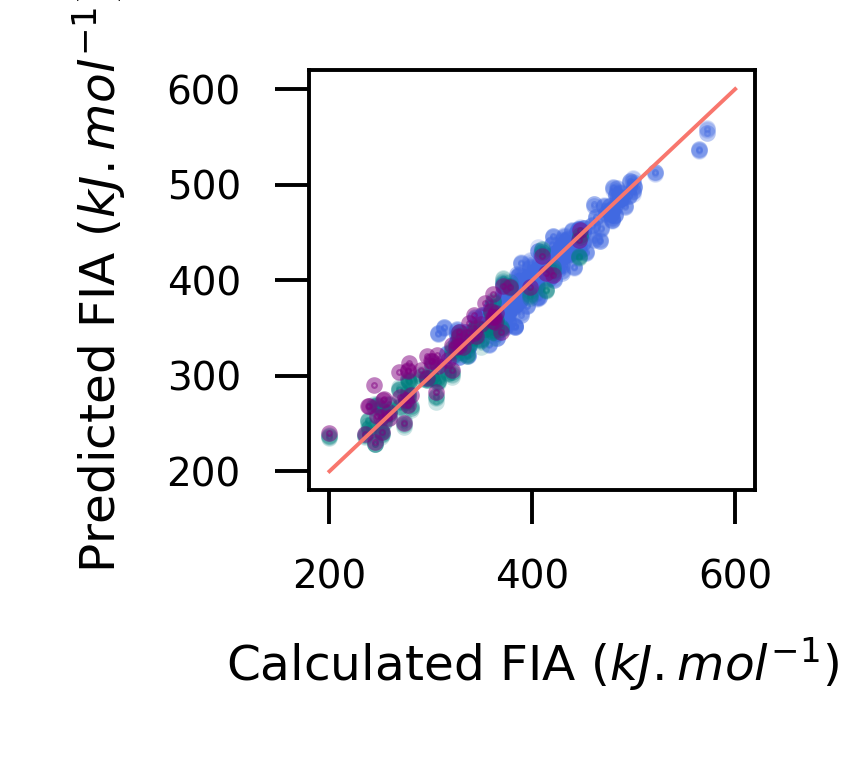

In [21]:
fig = plt.figure(figsize=(1.2,1.1))

ax2 = plt.subplot()

ax2.scatter(x=total_Y_S1_test_reduced, y=total_Y_S1_pred_test_reduced, marker = 'o', s = 0.5, c="royalblue", alpha=0.2, label =r"ONO $\rightarrow$ ONO")
ax2.scatter(x=total_Y_S2_test_reduced, y=total_Y_S2_pred_test_reduced, marker = 'o', s = 0.5, c="teal", alpha=0.2, label=r'NNN $\rightarrow$ NNN')
ax2.scatter(x=Y_S2, y=Y_pred_S2_train_S1_reduced,c = 'purple', marker = 'o', s = 0.5, alpha=0.5, label=r'ONO $\rightarrow$ NNN')
#plt.scatter(x = FIA_ONO_reduced, y = FIA_ONO_reduced, s = 80, c='g')
intervalle = np.linspace(200, 600, 100)
ax2.plot(intervalle, intervalle, "#F8766D", label = "y=x")

z = np.polyfit(Y_S2, Y_pred_S2_train_S1_reduced, 1)
p = np.poly1d(z)
	
#ax2.plot(Y_S2,p(Y_S2),"#F8766D", label = f"fit $y=a \cdot x+b$ \na = {round(z[0],2)} \nb = {round(z[1],2)}")
#print('r_b =', pearsonr(Y_S2,Y_pred_S2_train_S1_reduced) )

ax2.set_ylabel('Predicted FIA ($kJ.mol^{-1}$)', fontsize = 5)
ax2.set_xlabel('Calculated FIA ($kJ.mol^{-1}$)', fontsize = 5)
ax2.tick_params(labelsize = 4)
for line in ax2.lines:
	line.set_linewidth(0.4)
for spine in ax2.spines.values():
    spine.set_linewidth(0.4)
ax2.tick_params(width = 0.4)

#ax2.set_title('B.', loc='left', fontsize =10)
#ax2.legend(fontsize = 4.5, loc= 'lower right')

plt.tight_layout()

plt.show()

fig.savefig(f'../results/extrapolation/extrapolation_CV_Ridge_reduced_quantum_small.svg', format = 'svg', transparent = True, bbox_inches='tight', dpi = 400)

#### RDKit descriptors

In [12]:
descriptors = "rdkit"
S1 = 'ONO'
S2 = 'NNN'

names = get_names(descriptors)

reduced_features=names[:]
reduced_features.remove('FractionCSP3')
reduced_features.remove('BCUT2D_CHGHI')
reduced_features.remove('MinEStateIndex')
reduced_features.remove('SlogP_VSA2')



## create descriptors

X_S1, X_S1_reduced, Y_S1 = reduce_descr(S1, descriptors, names, reduced_features)
X_S2, X_S2_reduced, Y_S2 = reduce_descr(S2, descriptors, names, reduced_features)

In [13]:
np.shape(X_S1_reduced)

(272, 204)

In [15]:
model = 'LR'

reduced = 'False'

def gene_X_S1(reduced):
    if reduced == 'True':
        return(X_S1_reduced)
    else :
        return(X_S1)

def gene_X_S2(reduced):
    if reduced == 'True':
        return(X_S2_reduced)
    else :
        return(X_S2)
       
X_S1_extr = gene_X_S1(reduced)
X_S2_extr = gene_X_S2(reduced)

total_Y_S1_test, total_Y_S1_pred_test, list_MAE_S1 = K_Fold_model_evaluation(dict_models[model][descriptors],X_S1_extr,Y_S1,n_fold=10, n_repet=5)
total_Y_S2_test, total_Y_S2_pred_test, list_MAE_S2 = K_Fold_model_evaluation(dict_models[model][descriptors],X_S2_extr,Y_S2,n_fold=10, n_repet=5)


#extrapolation reduced features

Y_pred_S2_train_S1, MAE_S1_S2 = train_predict(X_S1_extr, X_S2_extr, Y_S1, Y_S2, dict_models[model][descriptors])

print(f"MAE {S1} = {round(np.mean(list_MAE_S1),2)}")
print(f"MAE {S2} = {round(np.mean(list_MAE_S2),2)}")
print(f"MAE {S1}->{S2} = {round(MAE_S1_S2,2)}")

MAE ONO = 6.95
MAE NNN = 10.39
MAE ONO->NNN = 1827.56


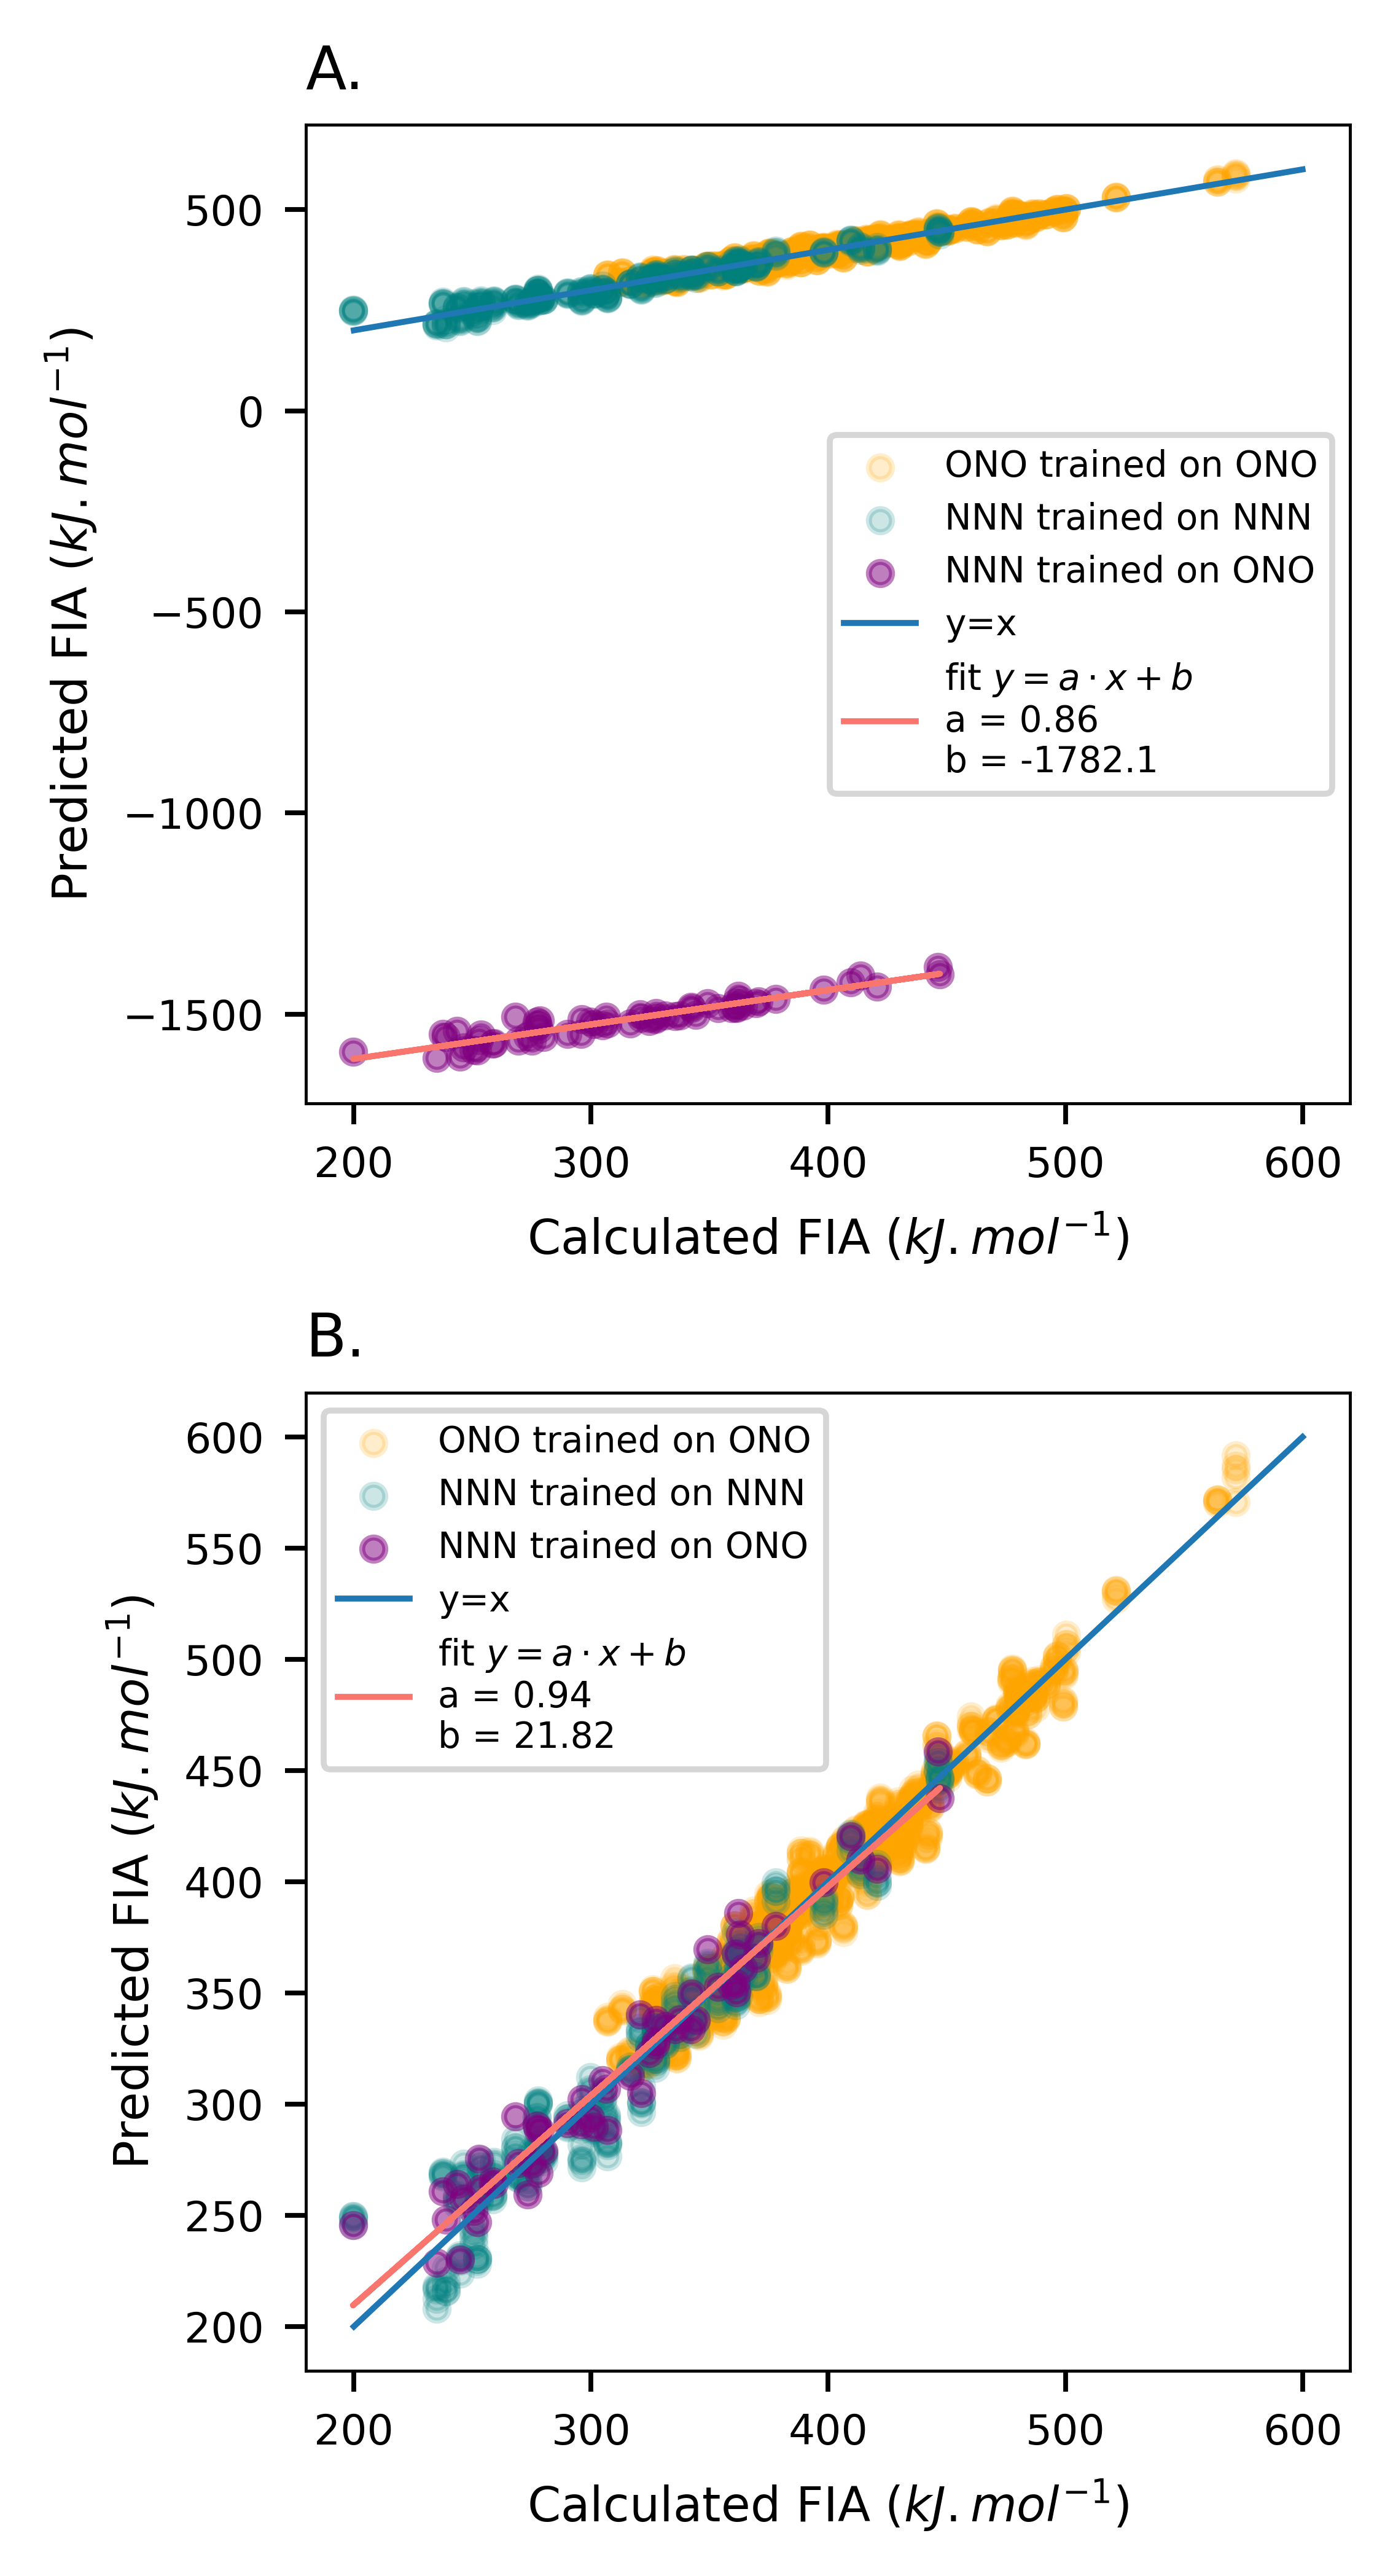

In [17]:
## plot 
fig = plt.figure(figsize=(3.25, 6))

ax1 = plt.subplot2grid((2, 1), (0, 0))

ax2 = plt.subplot2grid((2, 1), (1, 0))


## 1st graph

ax1.scatter(x=total_Y_S1_test, y=total_Y_S1_pred_test, s = 15, c="orange", alpha=0.2, label =f'{S1} trained on {S1}')
ax1.scatter(x=total_Y_S2_test, y=total_Y_S2_pred_test, s = 15, c="teal", alpha=0.2, label=f'{S2} trained on {S2}')
ax1.scatter(x=Y_S2, y=Y_pred_S2_train_S1,c = 'purple', s = 15, alpha=0.5, label=f'{S2} trained on {S1}')
#plt.scatter(x = FIA_ONO_reduced, y = FIA_ONO_reduced, s = 80, c='g')
intervalle = np.linspace(200, 600, 100)
ax1.plot(intervalle, intervalle, label = "y=x")

z = np.polyfit(Y_S2, Y_pred_S2_train_S1, 1)
p = np.poly1d(z)
    
ax1.plot(Y_S2,p(Y_S2),"#F8766D", label = f"fit $y=a \cdot x+b$ \na = {round(z[0],2)} \nb = {round(z[1],2)}")

ax1.set_ylabel('Predicted FIA ($kJ.mol^{-1}$)')
ax1.set_xlabel('Calculated FIA ($kJ.mol^{-1}$)')

ax1.set_title('A.', loc='left', fontsize =10)
ax1.legend()


## 2nd graph

ax2.scatter(x=total_Y_S1_test_reduced, y=total_Y_S1_pred_test_reduced, s = 15, c="orange", alpha=0.2, label =f'{S1} trained on {S1}')
ax2.scatter(x=total_Y_S2_test_reduced, y=total_Y_S2_pred_test_reduced, s = 15, c="teal", alpha=0.2, label=f'{S2} trained on {S2}')
ax2.scatter(x=Y_S2, y=Y_pred_S2_train_S1_reduced,c = 'purple', s = 15, alpha=0.5, label=f'{S2} trained on {S1}')
#plt.scatter(x = FIA_ONO_reduced, y = FIA_ONO_reduced, s = 80, c='g')
intervalle = np.linspace(200, 600, 100)
ax2.plot(intervalle, intervalle, label = "y=x")

z = np.polyfit(Y_S2, Y_pred_S2_train_S1_reduced, 1)
p = np.poly1d(z)
    
ax2.plot(Y_S2,p(Y_S2),"#F8766D", label = f"fit $y=a \cdot x+b$ \na = {round(z[0],2)} \nb = {round(z[1],2)}")

ax2.set_ylabel('Predicted FIA ($kJ.mol^{-1}$)')
ax2.set_xlabel('Calculated FIA ($kJ.mol^{-1}$)')

ax2.set_title('B.', loc='left', fontsize =10)
ax2.legend()

plt.tight_layout()

plt.show()

fig.savefig(f'../results/extrapolation/extrapolation_CV_Ridge_reduced_rdkit.png', facecolor = 'white', format = 'png', transparent = True, bbox_inches='tight')

In [20]:
reduced_features_rdkit = reduced_features

In [31]:
descriptors = 'rdkit'
names = get_names(descriptors)

df_training_3_str = pd.DataFrame(columns = ['ONO', 'NNN', 'OCO', 'triarylboranes'])

for structure in df_training_3_str.columns:
    print(structure)
    #S_test = structure
    L = list(df_training_3_str.columns)
    L.remove(structure)
    S_train_1, S_train_2, S_train_3 = L[0], L[1], L[2]
    print("training structure are", S_train_1, S_train_2, S_train_3)
    df_train = df_total[(df_total.group == S_train_1) | (df_total.group == S_train_2) | (df_total.group==S_train_3)]
    df_test = df(structure)
    X_train = create_descriptors(df_train.index, descriptors, data=data_Q_tot)
    df_X_train = pd.DataFrame(X_train)
    df_X_train.columns = names
    df_X_train_reduced = df_X_train.loc[:,reduced_features_rdkit]
    X_train_reduced = np.array(df_X_train_reduced)
    Y_train = df_train.FIA

    X_test = create_descriptors(df_test.index, descriptors, data=data_Q_tot)
    df_X_test = pd.DataFrame(X_test)
    df_X_test.columns = names
    df_X_test_reduced = df_X_test.loc[:,reduced_features_rdkit]
    X_test_reduced = np.array(df_X_test_reduced)
    Y_test = df_test.FIA
    Y_pred, MAE = train_predict(X_train_reduced, X_test_reduced, Y_train, Y_test, dict_models[model][descriptors])
    
    z = np.polyfit(Y_test, Y_pred, 1)
    df_training_3_str.at["performance",structure]=f'MAE = {round(MAE,2)} \na = {round(z[0],2)} \nb = {round(z[1],2)}'

ONO
training structure are NNN OCO triarylboranes
NNN
training structure are ONO OCO triarylboranes
OCO
training structure are ONO NNN triarylboranes
triarylboranes
training structure are ONO NNN OCO


In [33]:
df_training_3_str.to_excel('../results/extrapolation/extrapolation_performances_3_structures_training_selected_rdkit.xlsx')

In [41]:
X_tot = create_descriptors(df_ONO.index, "quantum", data = data_Q_tot)
df_X_tot = pd.DataFrame(X_tot, columns = get_names('quantum'))

In [42]:
df_X_tot['FIA']= list(df_ONO.FIA)

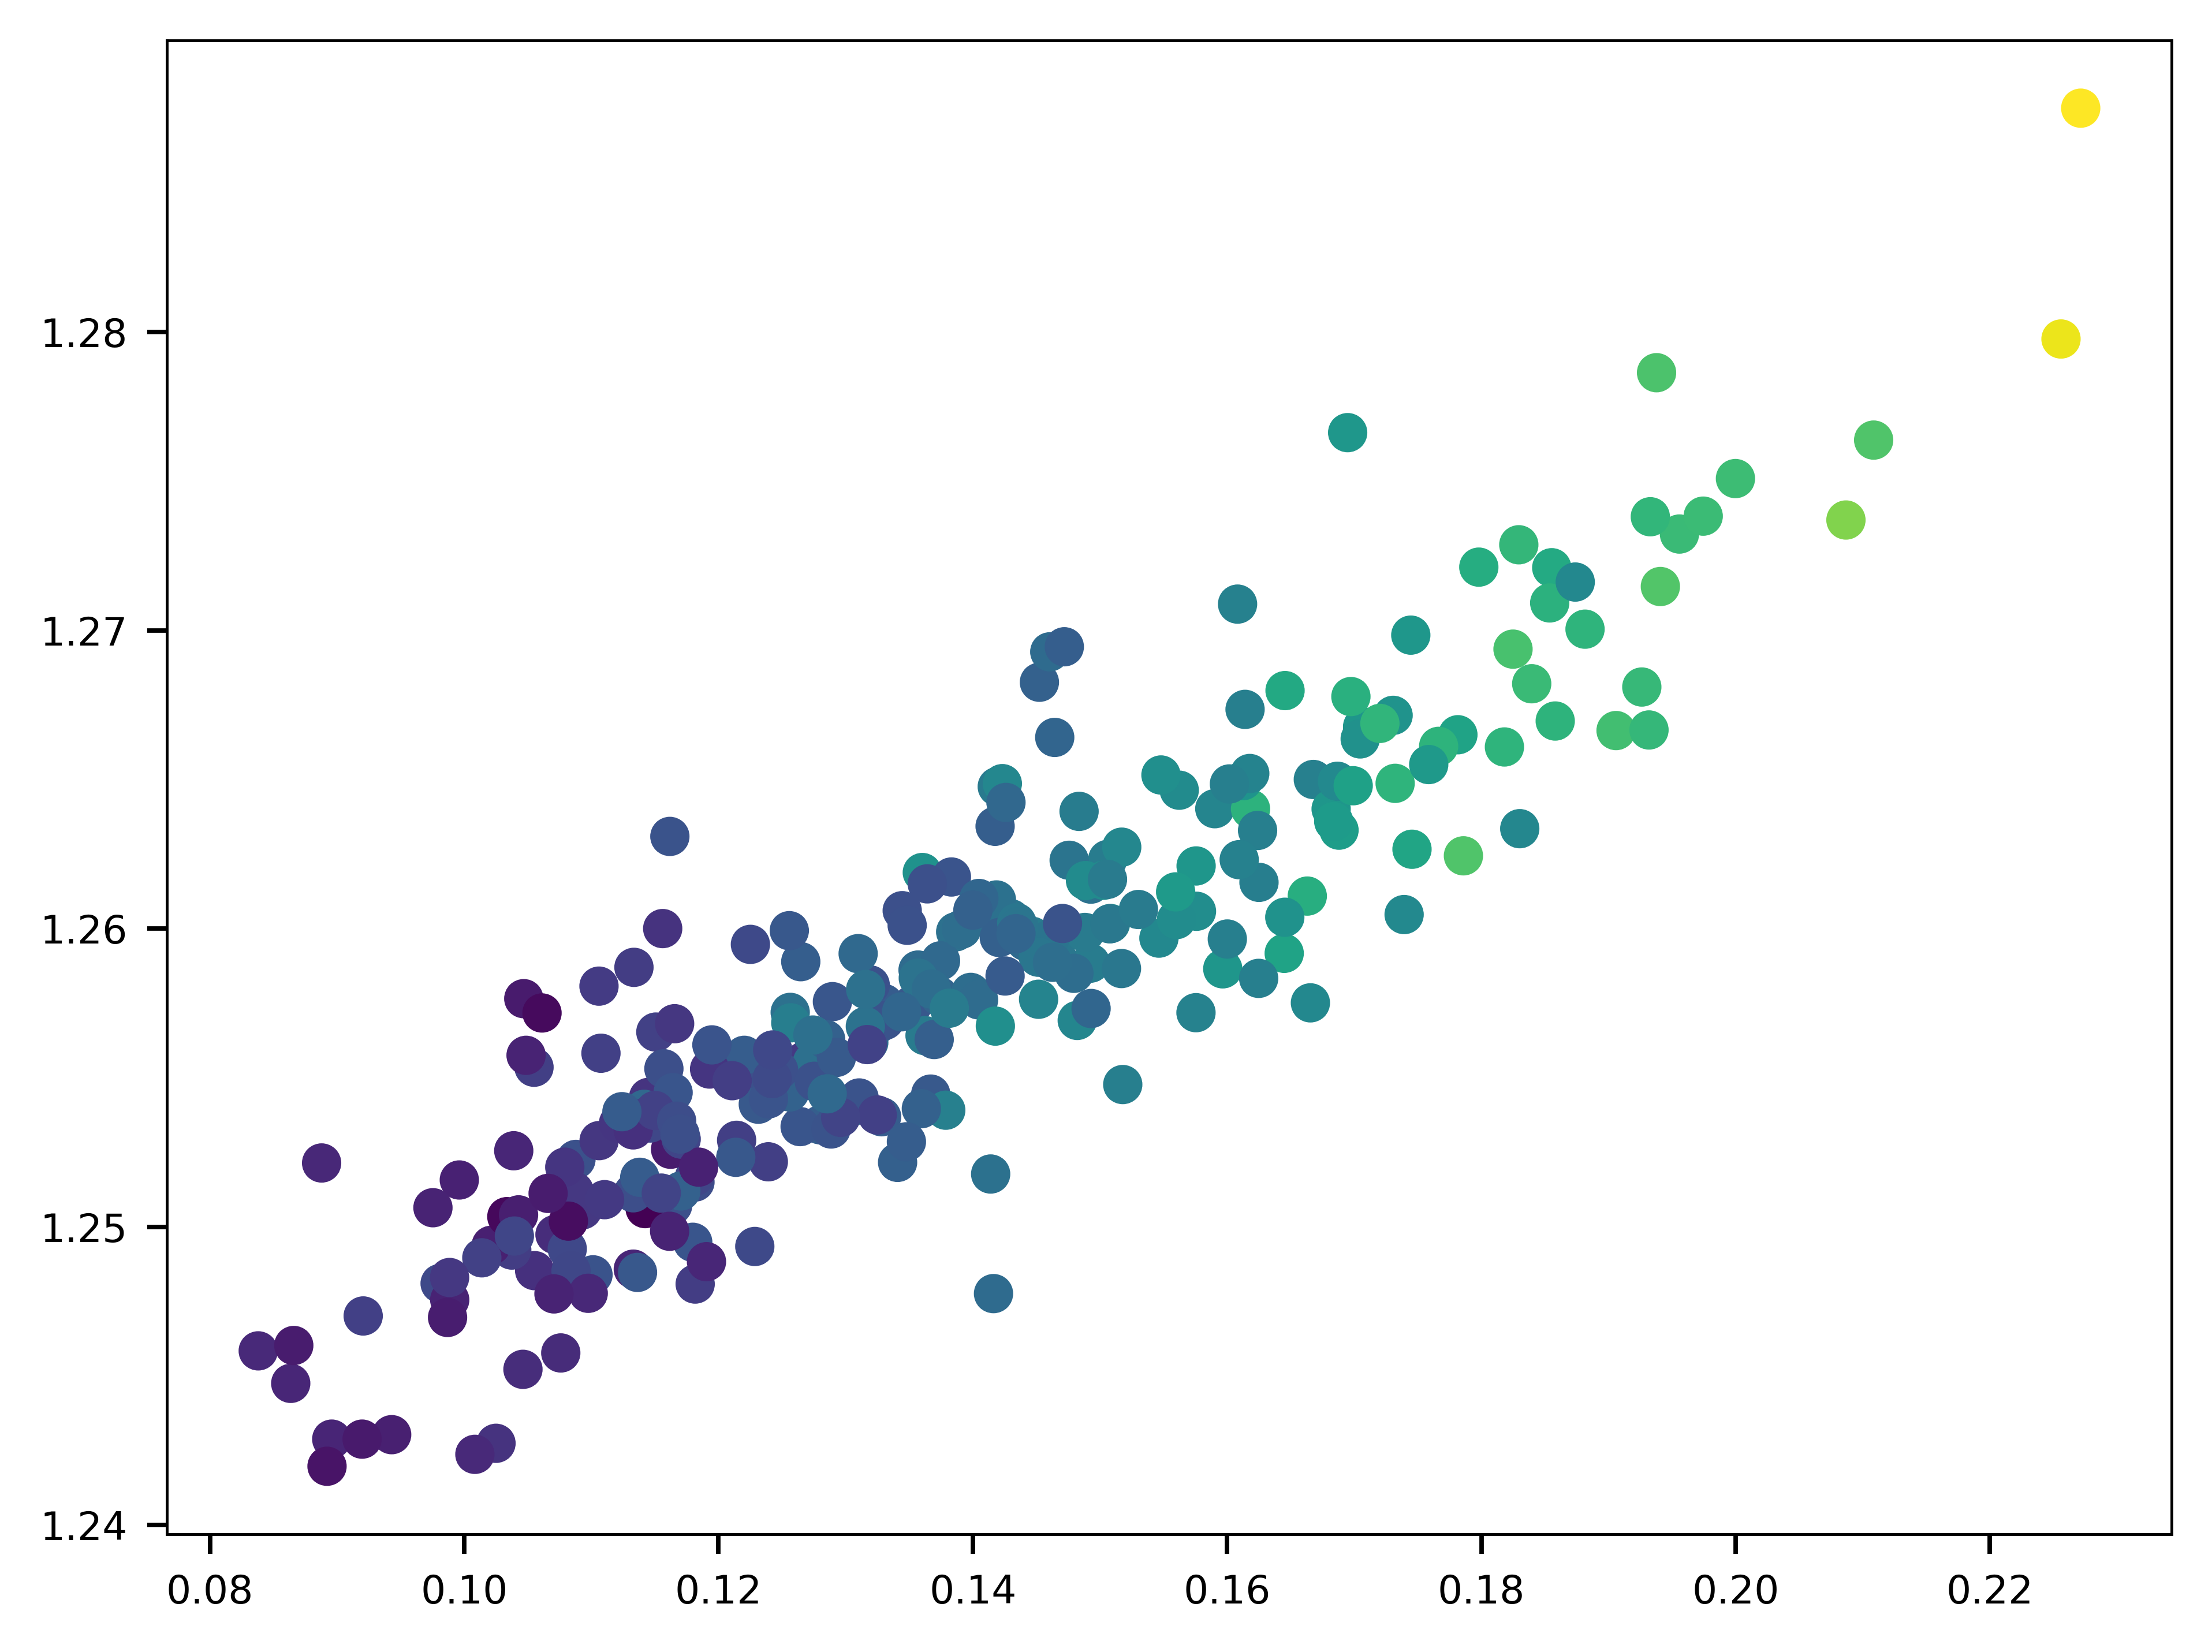

In [47]:
plt.scatter(df_X_tot['electronegativity'], df_X_tot['NPA_charge'], c = df_X_tot['FIA'])